<a href="https://colab.research.google.com/github/gardiens/MVA_24_25/blob/main/MVA_SAT/TP5/tp2_interferometry_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical work on SAR interferometry

### Florence Tupin, Christophe Kervazo, Emanuele Dalsasso

Images of the practical work can be found on:
https://perso.telecom-paristech.fr/tupin/TPSAR/

You have:
- Terrasar-X images of metric resolution on Grand canyon in Colorado.
- ERS-1/ERS-2 images acquired on Etna volcano.
For each pair of images, we will compute the interferogram.

Some useful functions are available in the file *mvalab.py*.

### Name: **WRITE YOUR NAME HERE**

#### Instructions

To solve this practical session, answer the questions below. Then export the notebook with the answers using the menu option **File -> Download as -> Notebook (.ipynb)**. Then [submit the resulting file here] https://partage.imt.fr/index.php/s/xsneCr8KPN4n2no by next week (deadline 21st of february).

### Import the libraries and packages we are going to use
The following cell imports all that is going to be necessary for the practical work

In [ ]:
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/mvalab.py

--2024-02-22 12:48:53--  https://perso.telecom-paristech.fr/tupin/TPSAR/mvalab.py
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68071 (66K) [text/x-python]
Saving to: ‘mvalab.py’

mvalab.py           100%[===================>]  66.48K  --.-KB/s    in 0.08s   

2024-02-22 12:48:53 (834 KB/s) - ‘mvalab.py’ saved [68071/68071]



In [ ]:
import scipy
from scipy import signal
import scipy.signal
import scipy as spy
import scipy.fftpack
from scipy import ndimage
from scipy import special
from scipy import ndimage
import numpy as np
import math
import matplotlib.pyplot as plt
import mvalab as mvalab
from urllib.request import urlopen
import cmath


plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.max_open_warning'] = 30

## A. Visualization of the Grand Canyon and its interpretation

To recall from the previous practical work:
* Download of images using `mvalab.imz2mat`
* Visualization of amplitude images, phase and Fourier spectrum. Useful functions:
    * `mvalab.visusar`
    * `mvalab.visuinterfero` and `np.angle`
    * `mvalab.visusarspectre`

### Visualization of an image

The function to display a SAR image with an adapted thresholding of the values is
`mvalab.visusar`. The first argument containing the image is compulsary, and the second one is
optional and corresponds to a threshold for the display.
The value $\alpha$ defines the threshold in this way :

${\rm thres} \:\:=\:\: {\rm vmean} \:\: + \:\: \alpha \: {\rm std}$


vmean is the mean value and std the standard deviation computed on the whole image. Every pixel whose value is above this threshold is displayed with the maximal value.  

When $\alpha$ is 0, the image is displayed with the full dynamic range.
A usual value to display SAR images is 3.

### Vizualisation of a phase image

Use `mvalab.visuinterfero` on the phase (do not forget the `np.angle` function, and to set the full range dynamic).

### Spectral analysis
To visualize an image and its spectrum (with automatic thresholding for the display), use the function `mvalab.visusarspectre`.


   

In [ ]:
url='https://perso.telecom-paristech.fr/tupin/TPSAR/imagesinterf/'
imagesar=mvalab.imz2mat(url+'TSX_GC_maitre.cxs')
tableauimage=imagesar[0]
ncol=imagesar[1]
nlig=imagesar[2]

imz2mat : version janvier 2018.  Fichier à ouvrir : https://perso.telecom-paristech.fr/tupin/TPSAR/imagesinterf/TSX_GC_maitre.cxs
Nom compatible url
Nom compatible url
Complex short, Fichiers Unix
INFO - reading header/dim : https://perso.telecom-paristech.fr/tupin/TPSAR/imagesinterf/TSX_GC_maitre.dim
lecture .dim OK -> largeur:2048 hauteur:2048 profondeur:1
Debug 2 2 2048
2 2048 >h


Affichage d'une image complexe : on prend le module
plt.show dans visusar : image 2048 x 2048


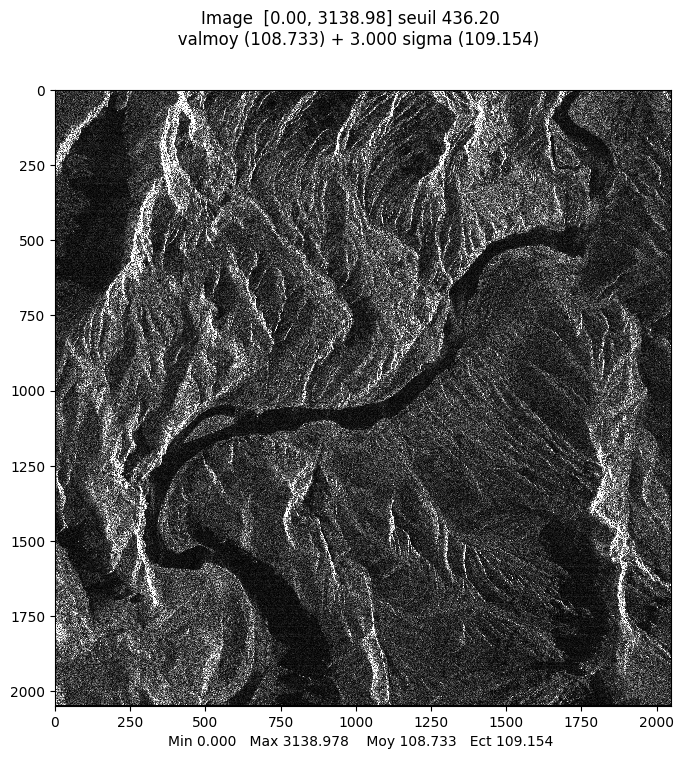

Affichage d'une image reelle
plt.show dans visusar : image 2048 x 2048


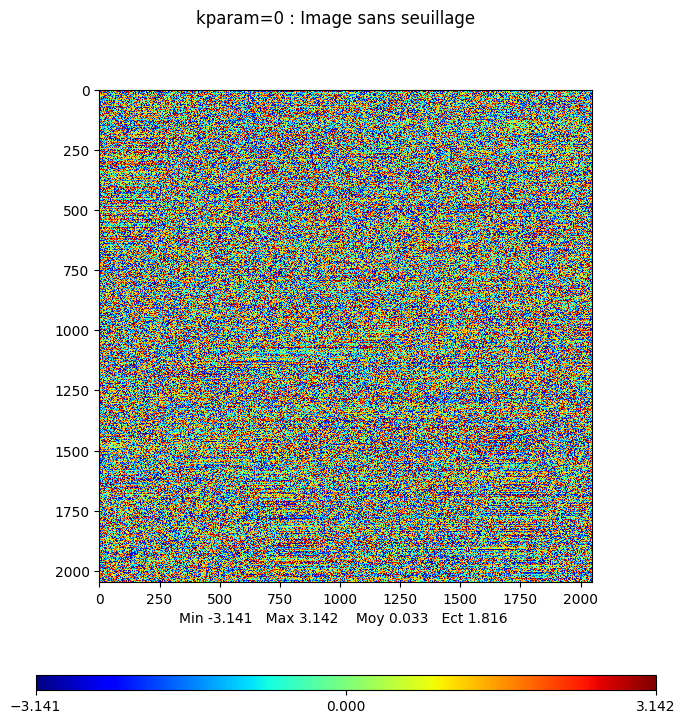

Affichage d'une image complexe : on prend le module
Visusar sans plt.show, ni titre
Affichage d'une image complexe : on prend le module
Visusar sans plt.show, ni titre


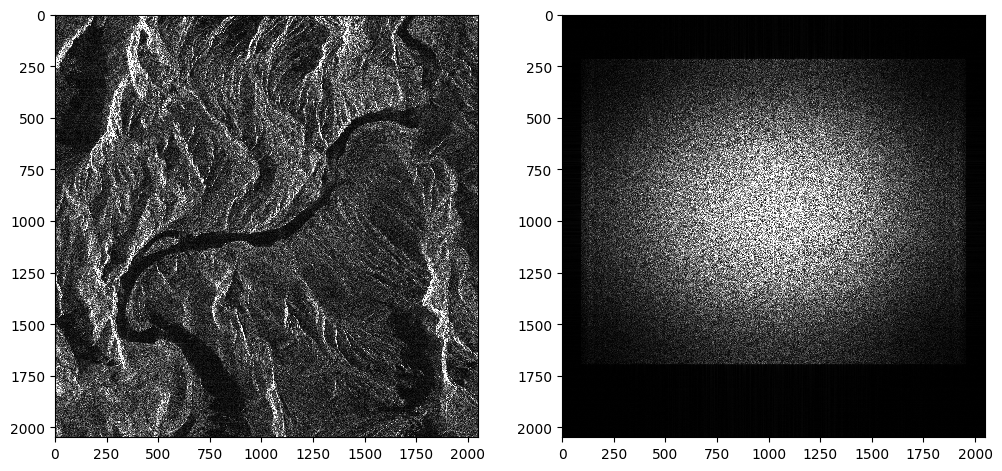

In [ ]:
mvalab.visusar(tableauimage)
mvalab.visuinterfero(np.angle(tableauimage),0)
mvalab.visusarspectre(tableauimage)

## B. Terrasar-X data on Grand Canyon (Airbus): computation of the interferogram

##### Parameters values for the TerraSAR-X data
These are free data provided by Airbus of Grand Canyon, Colorado, US.
The parameters of the sensor for this acquisition are the following:
- $\theta = 39.15^{\rm o}$  (for the master image)
- $R$ = 646 km  (hypothesis of spheric earth)
- $\lambda$ = 3.11 cm
- $B_{ortho}$ = 46.5 m
- $F_e$ = 109.89 MHz

These values will be used in the following to compute the contribution of the phase ramp corresponding to the orbital fringes.

### Registration of the two original SAR images: pixellic registration
The two images to consider are the following:
- TSX_GC_maitre.cxs
- TSX_GC_esclave.cxs

These images are complex images. Thus we have the phase information, which, to recall, is directly linked to the distance between the radar and the ground ($\phi=4\pi R / \lambda$).
They are given in their original geometry of acquisition.
Thus, they are not directly super-imposable and we must register the slave image on the master one.

To do a registration at the pixel scale, you can find the maximum of the cross-correlation between the two amplitude images $a_1$ and $a_2$, being the maximum of

$\tilde{a}_1 \star a_2$

with $\tilde{a}_1(i,j) = a_1(-i,-j)$
This is done in the Fourier domain by computing the hermitian product of the two Fourier transforms.
Then the inverse Fourier tansform gives the correlation image:

$\tilde{a}_1 \star a_2 = \mathcal{F}^{-1}\{ \mathcal{F}\{a_1\}^{*} \cdot \mathcal{F}\{a_2\} \} $

### Question 1
Compute the translation to apply and give its value. What is the shift you obtain?

### Answer 1


imz2mat : version janvier 2018.  Fichier à ouvrir : https://perso.telecom-paristech.fr/tupin/TPSAR/imagesinterf/TSX_GC_maitre.cxs
Nom compatible url
Nom compatible url
Complex short, Fichiers Unix
INFO - reading header/dim : https://perso.telecom-paristech.fr/tupin/TPSAR/imagesinterf/TSX_GC_maitre.dim
lecture .dim OK -> largeur:2048 hauteur:2048 profondeur:1
Debug 2 2 2048
2 2048 >h
imz2mat : version janvier 2018.  Fichier à ouvrir : https://perso.telecom-paristech.fr/tupin/TPSAR/imagesinterf/TSX_GC_slave.cxs
Nom compatible url
Nom compatible url
Complex short, Fichiers Unix
INFO - reading header/dim : https://perso.telecom-paristech.fr/tupin/TPSAR/imagesinterf/TSX_GC_slave.dim
lecture .dim OK -> largeur:2048 hauteur:2048 profondeur:1
Debug 2 2 2048
2 2048 >h
Affichage d'une image complexe : on prend le module
plt.show dans visusar : image 2048 x 2048


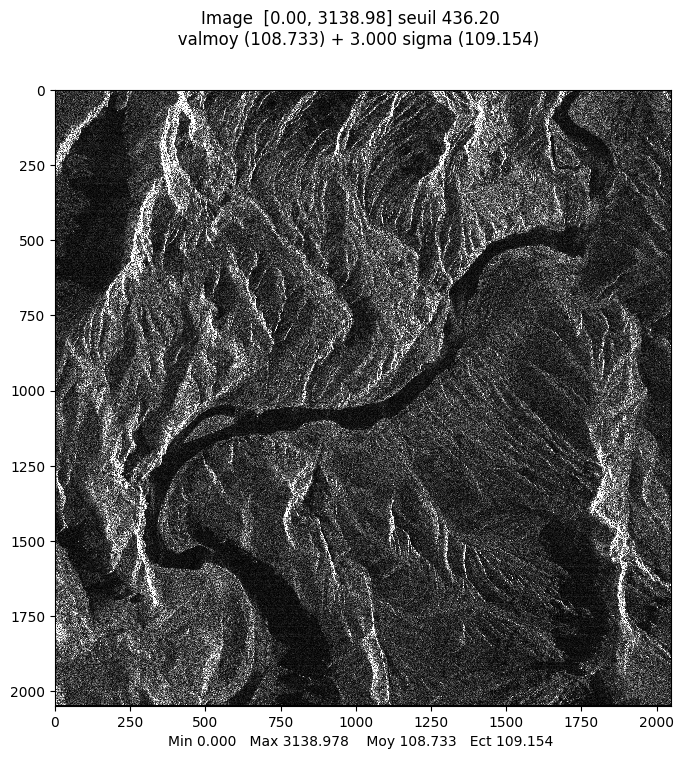

Affichage d'une image complexe : on prend le module
plt.show dans visusar : image 2048 x 2048


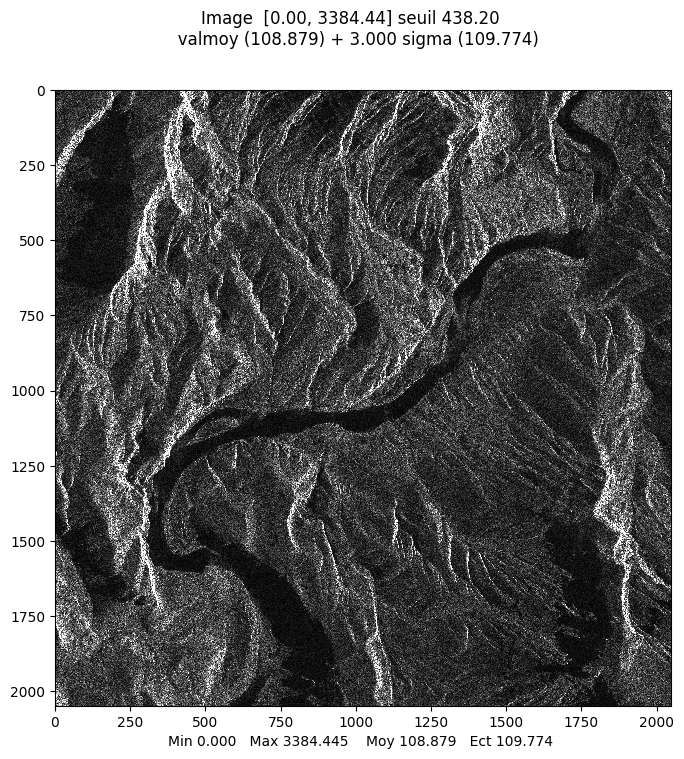

array([[  0.        ,  66.61080993,  22.20360331, ..., 131.487642  ,
        148.33745313,  88.52683209],
       [  0.        ,  36.76955262,  19.02629759, ..., 106.06601718,
        261.72504657, 293.12795841],
       [  0.        ,  78.23042886,  53.07541804, ...,   9.8488578 ,
        171.95929751, 314.24990056],
       ...,
       [  0.        ,  41.59326869,  92.76313923, ...,  94.5409964 ,
        177.07907838, 205.50669089],
       [  0.        ,  75.10659092, 159.76545309, ...,  58.00862005,
        138.3220879 , 213.97429752],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [ ]:
url='https://perso.telecom-paristech.fr/tupin/TPSAR/imagesinterf/'
imamaitre=mvalab.imz2mat(url+'TSX_GC_maitre.cxs')
imaslave = mvalab.imz2mat(url+'TSX_GC_slave.cxs')
mvalab.visusar(imamaitre[0])
mvalab.visusar(imaslave[0])

In [ ]:
#take a subpart of the image to highlight the phase shift
mvalab.visusar(imamaitre[0][:,:]) # to be completed
mvalab.visusar(imaslave[0][:,:]) # to be completed

In [ ]:
# compute cross-correlation
ima1fft=np.fft.fft2(np.abs(imamaitre[0]))
ima2fft=np.fft.fft2(np.abs(imaslave[0]))

imacorfft = np.multiply(, ) # to be completed
imacor=np.fft.ifft2(imacorfft)

mvalab.visusar(imacor)

# extract the index corresponding to the maximum value
idecalage=np.unravel_index(np.argmax(np.abs(imacor)), imacor.shape)
print('--- phase difference ---')
print(idecalage)

# compute the shift on the two axis
imaslaveroll=np.roll(imaslave[0], , axis=0) # to be completed
imaslaveroll=np.roll(imaslaveroll, , axis=1) # to be completed

### Question 2
Compute the interferogram by computing the hermitian product between the two registered images (pixel by pixel, 1-look interferogram). What do you see ? Compare with the interferogram before doing the registration.

### Answer 2

In [ ]:
# compute the interferogram and plot the interferometric phase
interfero=np.multiply(,  ) # to be completed
mvalab.visuinterfero(np.angle(interfero)+math.pi,0)

### Orbital fringe correction: subpixellic registration
The two images are almost registered but in practice the ground cells are slightly different since they have not been taken under the exact same incidence angle.  

For an image with *n* columns, the phase shift is (see course)

$\Delta \phi = \frac{4\pi B_{orth} cos\theta}{\lambda R} n\Delta x$

with

$\Delta x = \frac{c}{2F_{e}sin\theta}$  


To take into account this phase shift for each pixel, apply a phase shift, "dephasage" value being the whole phase shift for the number of pixels in range of the image.




```
rampephase=np.linspace(0.,dephasage,ncolonnes)
malignephase=np.exp(1j*rampephase)
imaslavefine=np.multiply(imaslaveroll,malignephase)
```


In [ ]:
# Parameters of the sensor
theta = 39.15*np.pi/180 #rad
lambd = 3.11e-2 #m
Fe = 109.89e6 #Hz
Borth = 46.5 #m
R = 646e3 #m
c = 3e8 #m/s

# Compute the phase shift
delta_x = # to be completed
dephasage =  # to be completed (global phase shift for the whole image)

# Compute the phase shift for each image pixel for one line in an array
rampephase= # to be completed

plt.figure()
plt.plot(rampephase)
plt.show()

malignephase= # to be completed

# Visualize the orbital fringes
orbital_fringes = np.ones((imamaitre[0].shape), dtype=np.complex128)
for juv in range(imamaitre[2]):
    orbital_fringes[juv,:]= malignephase
plt.figure()
plt.imshow(np.angle(orbital_fringes),cmap='jet')
plt.show()

# Register the slave image
imaslavefine = # to be completed

#compute the new interferogram and comment the effect of the fine registration




### Question 3
Compute the interferogram by computing the hermitian product between the two finely registered images (pixel by pixel, 1-look interferogram). What do you see ?

### Answer 3

### Computation of the filtered interferogram
To compute now the interferometric product, you have to compute the multi-look hermitian product given by the formula :

$d(i,j)= {\gamma(i,j) e}^{j \phi(i,j)}$

$d(i,j)=\frac{\sum_{(i',j') \in {{V}}(i,j)} I_m(i',j')I_s^*(i',j')}
{
\sqrt{\sum_{(i',j') \in {{V}}(i,j)} I_m(i',j')I_m^*(i',j')}
\sqrt{\sum_{(i',j') \in {{V}}(i,j)} I_s(i',j')I_s^*(i',j')} }
$

the usual neighborhood is a square of size 3$\times$3 pixels.
It gives :
- the interferometric phase (argument of the output, $\phi(i,j)$)
- the coherence (modulus of the output $\gamma(i,j)$ ) reflecting the quality of the interferometric phase


### Question 4
Compute and compare the interferometric product for the two images (master and slave) in the following cases:
- using the raw images, without any correction
- with the pixellic registration
- with the sub-pixellic phase shift

You can fill the python function "interferogramme" to compute the complex interferogram.

Comment the differences between the three inteferograms.
Try to modify the size of window used to compute the multilooked interferogram and explain what happens.

### Answer 4

In [ ]:
def interferogramme( tabvignette, tabvignette2, *therest) :
    """
    Computation of the complex interferogram between two images of the
    same size.
    By default, window size is set as 3x3 (dimx, dimy).
    It outputs a complex image, whose modulus is the coherence and whose phase
    is the interferometric phase.
    """

    dimx=3
    dimy=3

    if(len(therest)==1):
        dimx=therest[0]
        dimy=dimx

    if(len(therest)==2):
        dimx=therest[0]
        dimy=therest[1]

    nlig=np.size(tabvignette,0)
    ncol=np.size(tabvignette,1)

    if nlig != np.size(tabvignette2,0)  :
        print(u'les deux images doivent avoir la même taille (%d  et %d)'%(nlig, np.size(tabvignette2,0)))
        return 0

    if ncol != np.size(tabvignette2,1)  :
        print(u'les deux images doivent avoir la même taille')
        return 0

    # single look interferogram before averaging
    interf= np.multiply(tabvignette, np.conj(tabvignette2))

    # part to be completed to compute a multi-look interfergram by averaging on a local window
    mask = # to be completed (to do an averaging with dim x and dimy window size)
    interfiltr = # to be completed - numerator part

    den1 = # to be completed - denominator part for tabvignette
    den2 = # to be completed - denominator part for tabvignette2

    return interfiltr/(den1*den2+1e-12)

In [ ]:
# compute the interferogram
interf=interferogramme(, , , ) # here you can modify the size of the local window

mvalab.visusar(np.abs(interf))
mvalab.visuinterfero(np.angle(interf),0)

In [ ]:
# COMPUTE THE COHERENCY on the image without subpixellic registration
interfnoramp=interferogramme(imamaitre[0], imaslaveroll)

mvalab.visusar(np.abs(interfnoramp))
mvalab.visuinterfero(np.angle(interfnoramp),0)

# COMPUTE THE COHERENCY on the image without any registration
interfnoramp=interferogramme(imamaitre[0], imaslave[0])

mvalab.visusar(np.abs(interfnoramp))
mvalab.visuinterfero(np.angle(interfnoramp),0)


### Question 5
Interpreting the fringes

When taking into account the phase shift due to pixel size differences, what do the left fringes
correspond to ?

Compute the ambiguity height given by :
    
$h_{amb} = \frac{\lambda R \: \sin \theta}{ 2 B_{ortho} }$

Which mean depth of the Grand Canyon can be deduced from the interferogram ? Explain.


### Answer 5

## C. ERS data of Etna (SARedu data)

The following parameters have to be used for these data:
- $\theta = 20^{\rm o}$ (on est en ``near range'')
-  $R$ = 826 km  (hypothèse de Terre sphérique)
-  $\lambda$ = 5.66 cm
-  $B_{ortho}$ = -54.5 m
-  $F_e$ = 18.96 MHz

Do the same processing as before with these new data.


In [ ]:
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/interfero/Master.mat
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/interfero/Slave.mat

In [ ]:
imageM='./Master.mat'
imageS='./Slave.mat'
imamaitre=mvalab.matlab2imz(imageM,'Master')
imaslave=mvalab.matlab2imz(imageS,'Slave')

ncolonnes=imamaitre[1]
nlignes=imamaitre[2]

#%%

mvalab.visusar(imamaitre[0])
mvalab.visusar(imaslave[0])

### Pixellic registration

In [ ]:
ima1fft=np.fft.fft2(np.abs(imamaitre[0]))
ima2fft=np.fft.fft2(np.abs(imaslave[0]))

# using the multiplication in the Fourier domain, compute the FFT of the correlation and then the correlation by inverse FFT
imacorfft = # to be completed
imacor= # to be completed

#visualize the correlation image (maximum gives the translation value)
mvalab.visusar(imacor)

# extract the index corresponding to the maximum value
idecalage=np.unravel_index(np.argmax(np.abs(imacor)), imacor.shape)
print('--- phase shift ---')
print(idecalage)

# compute the shift on the two axis - to be completed
imaslaveroll=np.roll(imaslave[0], , axis=0)
imaslaveroll=np.roll(imaslaveroll, , axis=1)

# compute the interferogram and plot the interferometric phase
interfero= # to be completed

mvalab.visuinterfero(np.angle(interfero)+math.pi,0)
mvalab.visusarspectre(imamaitre[0])

### Question 6
What is the pixel phase shift in this case ?

### Answer 6

### Subpixellic registration

In [ ]:
theta =  #rad
lambd = 0.0566 #m
Borth = 54.5 #m
R = 826000 #m
c = 299792458 #m/s
Fe =  #Mhz

# Compute the global phase shift
delta_x = # to be completed
ncolonnes=imamaitre[1]
dephasage_glob = # to be completed

# compute the phase shift for each pixel and plot it
rampephase=np.linspace(0.,dephasage_glob,ncolonnes)
plt.figure()
plt.plot(rampephase)
plt.show()

malignephase=np.exp(1j*rampephase)

# Visualize the orbital fringes
orbital_fringes = np.ones((imamaitre[0].shape), dtype=np.complex128)
for juv in range(imamaitre[2]):
    orbital_fringes[juv,:]= malignephase
plt.figure()
plt.imshow(np.angle(orbital_fringes),cmap='jet')
plt.show()

# Compensate the orbital fringe contribution by multiplying the registered slave image with malignephase
imaslavefine= # to be completed

### Computation of the filtered interferogram


In [ ]:
interf= # to be completed

mvalab.visusar(np.abs(interf))
mvalab.visuinterfero(np.angle(interf),0)

### Question 7
What is the ambiguity height ?


### Question 8
Which altitude do you find for Etna mount using your interferogram ? (explain)

### Question 9
Which are the areas of low coherence ? Explain why.